# Linear regression
## A workflow with hypothesis testing

We know the typical equation of a model of linear regression as it is:

$ \hat{y} = \beta_{0} + \beta_{1}x_1 + \beta_{2}x_2 + ... + \beta_{n}x_n $

* $ \beta_{0} $ represents the y intercept of line
* From $ \beta_{1} $ to $ \beta_{N} $ we have the weights or coefficients of the variables
* From $ x_1 $ to $ x_n $ are represented the variables
* $ \hat{y} $ represents the predicted $y$ value

Our first step is to represent the model into a matrix form so that:

$ Xa^T  =  \hat{y} $

By assuming an univariate model, which we'll use for clarity of the exposition, the equation will be reduced to the form:

$\hat{y} = \beta_{0} + \beta_{1}x$

If we rewrite the equation in a more "statistical" form we could say that:

$E(Y|x) = \beta_{0} + \beta_{1}x$

When we talk about **hypotesis testing** we assume a null hypothesis ($H_{0}$) and an alternative hypothesis ($H_{A}$); in the specific linear regression case, we assume that:

$H_{0} : \beta_{1} = 0$

so that

$E(Y) = \beta_{0}$

it means that the expected value of $Y$ is equal to $\beta_{0}$ for each and every x value and that the value of the x has no effect whatsoever. In other words, we are not able to find a statistical significance whether the increase or decrease of the x values yields to an increase or decrease of the y values. In the other situation:

$H_{A} : \beta_{1} \neq 0$

and:

$E(Y|x) = \beta_{0} + \beta_{1}x$

showing that, in a randomized sample, changes in x produce changes in y.

We'll work on these two assumptions by creating some random data.

In [13]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [14]:
regression_data = make_regression(n_samples=500, n_features=5, n_informative=2, random_state=42)

df = pd.concat([pd.DataFrame(regression_data[0]), pd.Series(regression_data[1])], axis=1)
df.columns = ['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'label']


In [15]:
df.corr()['label']

feat_1    0.671323
feat_2    0.050809
feat_3    0.005841
feat_4    0.743749
feat_5   -0.022081
label     1.000000
Name: label, dtype: float64

For this workflow we'll use ```feat_4``` that has the highest correlation score and ```feat_3``` that shows the lowest values. This should help us define some clear scores for our tests.

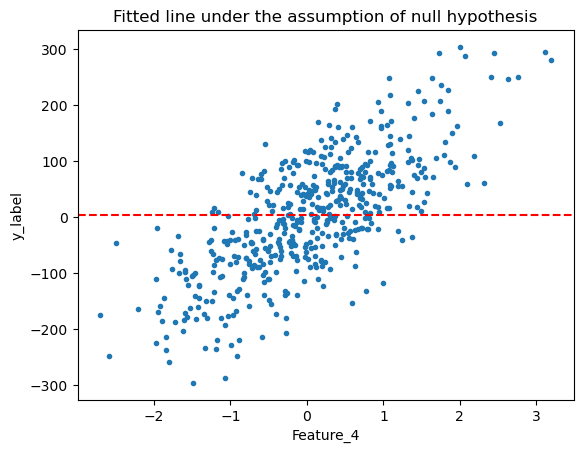

In [16]:
plt.scatter(df['feat_4'], df['label'], marker='.')
plt.xlabel('Feature_4')
plt.ylabel('y_label')
plt.axhline(df['label'].mean(), ls='--', c='red')
plt.title('Fitted line under the assumption of null hypothesis')
plt.show()

In [17]:
h_null_line = pd.Series([df['label'].mean() for i in range(df.shape[0])])
SSE_h0 = np.sum((df['label'] - h_null_line) ** 2)
print(round(SSE_h0, 2))

5656808.24


We can see from the graph above that the red line around the y mean doesn't seem to do a great job in predicting the values. This is our assumption of null hypothesis we talked before, let's see with the line fitted by calculating least square distances.

In [18]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

X = df['feat_4'].to_numpy()
target = df['label']
lr.fit(X.reshape(1, -1).T, target)


LinearRegression()

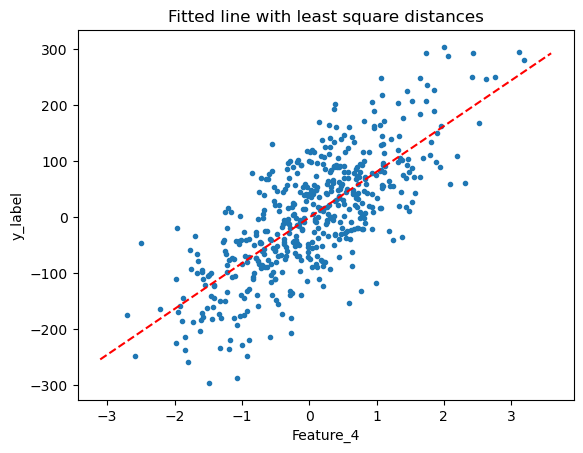

In [19]:
b_0 = lr.intercept_
b_1 = lr.coef_

x = np.linspace(X.min() - 0.4, X.max() + 0.4, 500)
y = b_0 + (b_1*x)

plt.scatter(X, target, marker='.')
plt.xlabel('Feature_4')
plt.ylabel('y_label')
plt.plot(x, y, color='red', ls='--')
plt.title('Fitted line with least square distances')
plt.show()

In [20]:
SSE_alt = np.sum((df['label'] - lr.predict(X.reshape(1, -1).T)) ** 2)
print(round(SSE_alt, 2))

2527672.89


The fitted line above seems to do a better job than the line we modelled under the assumption of null hypothesis but how can we decide in a way that is statistically consisten?
The **F-test** comes in our help; what we have to do is calculate the *sum of square residuals* for both $H_{0}$ and $H_{A}$.

* $SSE(H_{0}) = 5656808.24$
* $SSE(H_{A}) = 2527672.89$

The two quantities are very different, but for being completely sure we'll have to calculate the **F-statistic** which is:

$F=\left( \dfrac{SSE(H_{0})-SSE(H_{A})}{df_{H_{0}}-df_{H_{A}}}\right)\div\left( \dfrac{SSE(H_{A})}{df_{H_{A}}}\right)$

From the formula above we can see how we calculate the difference among the error in the two models. The degrees of freedom are associated with each model and they somehow help us to standardize the results.

We use this test and its associated p-value to:
* being able to reject the null hypothesis (generally associated with a large F-value and a small p-value) and accept the alternative hypothesis
* not being able to reject the null hypothesis (associated with a small F-value and a large p-value).

One last comment about the degrees of freedom; in the **F-test** we set those values as follow:
* $df_{H_{A}} = n - 2$
* $df_{H_{0}} = n - 1$

Let's now calculate the **F-value**

In [21]:
from scipy.stats import f

df_null = df.shape[0] - 1
df_alt = df.shape[0] - 2

f_value = ((SSE_h0 - SSE_alt) / (df_null - df_alt)) / (SSE_alt/df_alt)

f_value

616.4996315655455

Having the **F-value**, we can now calculate the relative **p-value** by calculate the area that lays above our **F-value**. The **p-value** answer the question: "What is the probability to have a **F-value** equal or larger of the one we have if $H_{0}$ is true?"

In [22]:
p_value = 1 - f.cdf(f_value, dfn=1, dfd=df_alt)
print(p_value)

1.1102230246251565e-16


Extremely low indeed; this means we can reject the null hypothesis and accept the model with both intercept and coefficient.
We'll now run the same test with some different data (data which are not highly correlated) and see what happen (if we are able to reject the null hypothesis or not).

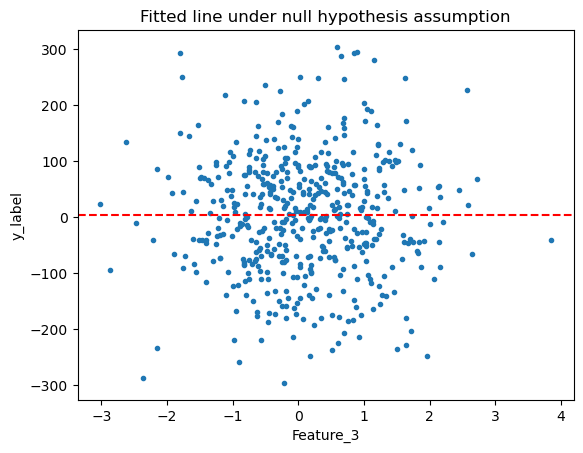

In [23]:
new_X = df['feat_3'].to_numpy()
target = df['label']

plt.scatter(new_X, target, marker='.')
plt.xlabel('Feature_3')
plt.ylabel('y_label')
plt.axhline(target.mean(), ls='--', c='red')
plt.title('Fitted line under null hypothesis assumption')
plt.show()

We can see that the data are kind of sparse all around; we're not able, at least visually, any linear relation between the variables. We'll now try to fit a line with least square method and see what happen.

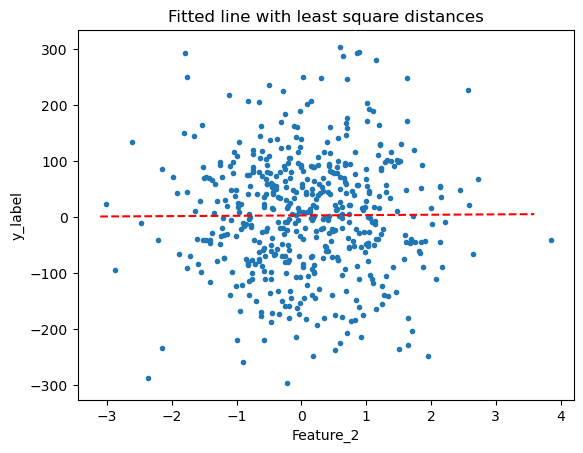

In [24]:
lr = LinearRegression()
lr.fit(new_X.reshape(1, -1).T, target)

b_0 = lr.intercept_
b_1 = lr.coef_

x = np.linspace(X.min() - 0.4, X.max() + 0.4, 500)
y = b_0 + (b_1*x)

plt.scatter(new_X, target, marker='.')
plt.xlabel('Feature_2')
plt.ylabel('y_label')
plt.plot(x, y, color='red', ls='--')
plt.title('Fitted line with least square distances')
plt.show()

Even the fitted line with least square method doesn't seem to do a great job in predict our target variable; in fact we know that:
* $\beta_{0} = 3.45$
* $\beta_{1} = 0.62$

If we consider that $\overline{y}$ is 3.50, we can see that we didn't improve our model that much.
To be sure, we'll run the same **F-test**. Let's first calculate the sum of square residuals for $H_{A}$.

In [25]:
SSE_alt = np.sum((df['label'] - lr.predict(new_X.reshape(1, -1).T)) ** 2)
print(round(SSE_alt, 2))

5656615.26


In [26]:
df_null = df.shape[0] - 1
df_alt = df.shape[0] - 2

f_value = ((SSE_h0 - SSE_alt) / (df_null - df_alt)) / (SSE_alt/df_alt)

f_value

0.016990105858648512

In [27]:
p_value = 1 - f.cdf(f_value, dfn=1, dfd=df_alt)
p_value

0.8963452423066977

Given the high p-value, we are not able to reject the null hypothesis in which we were assuming the possibility that the "best" model was reduced to the sole intercept.

With this last consideration, I hope I clarified the statistical assumptions behind a linear regression model. These assumptions can be further used for feature selection in a multivariate model.